In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [82]:
# 날씨 데이터 불러오기
weather = pd.read_csv('./data/2000-01~2021-11m.csv', encoding='cp949')

weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   지점                   263 non-null    int64  
 1   지점명                  263 non-null    object 
 2   일시                   263 non-null    object 
 3   평균기온(°C)             263 non-null    float64
 4   평균최고기온(°C)           263 non-null    float64
 5   평균최저기온(°C)           263 non-null    float64
 6   최고기온(°C)             263 non-null    float64
 7   최저기온(°C)             263 non-null    float64
 8   최고기온 나타난날(yyyymmdd)  263 non-null    int64  
 9   최저기온 나타난날(yyyymmdd)  263 non-null    int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 20.7+ KB


In [83]:
# 날씨 데이터 전처리
weather["dateTime"] = pd.to_datetime(weather["일시"], format='%Y-%m')
weather['meanTemp'] = weather['평균기온(°C)']
weather['meanHighTemp'] = weather['평균최고기온(°C)']
weather['meanLowTemp'] = weather['평균최저기온(°C)']
weather['highTemp'] = weather['최고기온(°C)']
weather['lowTemp'] = weather['최저기온(°C)']

# 훈련셋 21년 6월까지
trainSet = weather.loc[:257,['dateTime','meanTemp','meanHighTemp','meanLowTemp']]

# 시험셋 21년 7월부터
testSet = weather.loc[258:,['dateTime','meanTemp','meanHighTemp','meanLowTemp']]

In [84]:
print(trainSet)

      dateTime  meanTemp  meanHighTemp  meanLowTemp
0   2000-01-01      -2.1           1.7         -5.7
1   2000-02-01      -1.7           2.6         -5.8
2   2000-03-01       6.3          11.4          1.7
3   2000-04-01      11.9          16.9          7.3
4   2000-05-01      17.5          22.7         12.9
..         ...       ...           ...          ...
253 2021-02-01       2.7           7.9         -2.2
254 2021-03-01       9.0          14.8          4.3
255 2021-04-01      14.2          19.5          9.5
256 2021-05-01      17.1          21.9         12.8
257 2021-06-01      22.8          27.6         18.9

[258 rows x 4 columns]


In [90]:
print(testSet)

      dateTime  meanTemp  meanHighTemp  meanLowTemp
258 2021-07-01      28.1          32.2         24.6
259 2021-08-01      25.9          29.7         22.8
260 2021-09-01      22.6          26.9         18.8
261 2021-10-01      15.6          20.5         11.6
262 2021-11-01       8.2          13.1          4.0


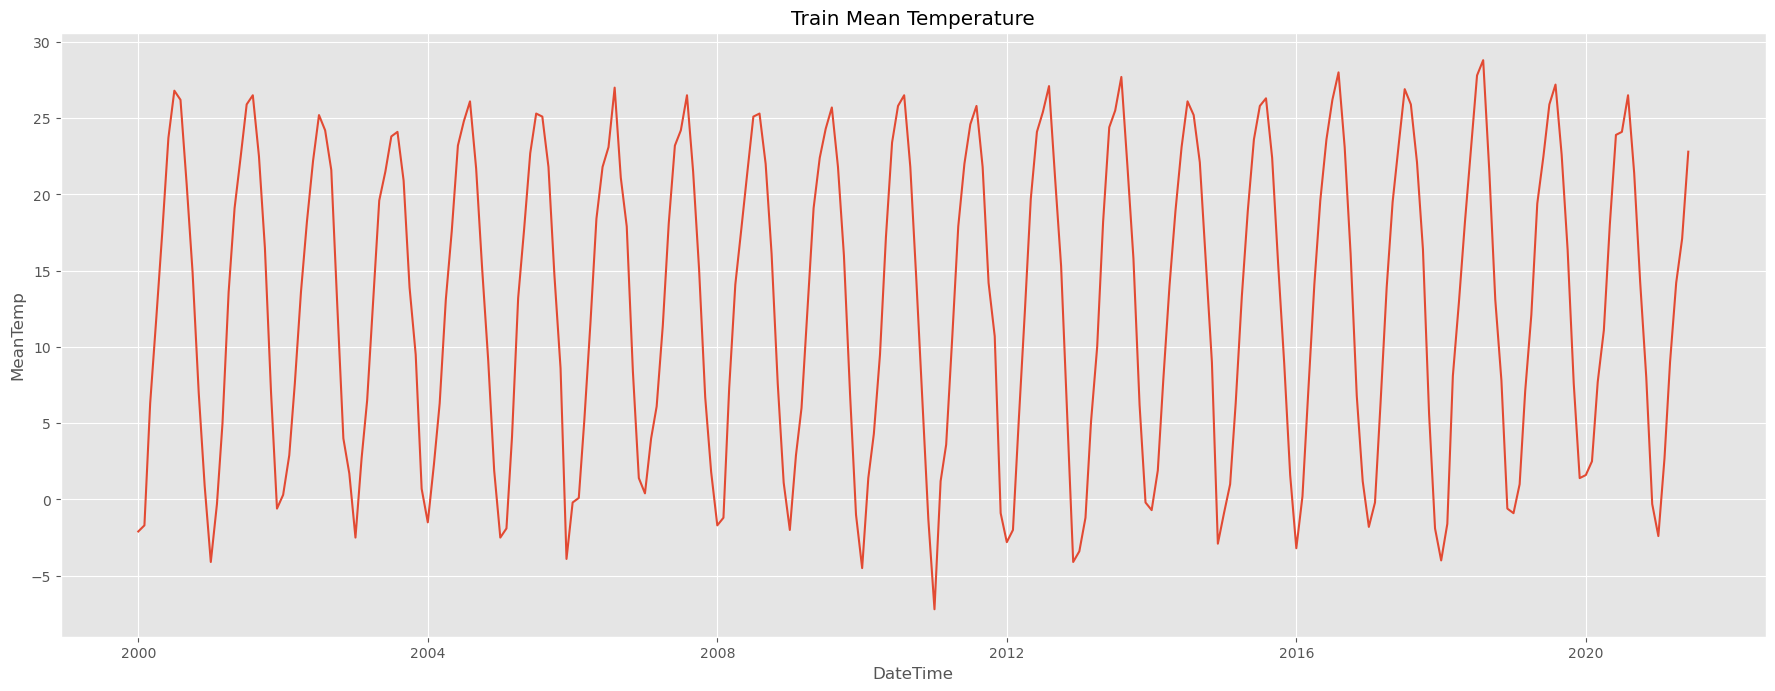

In [91]:
# 훈련셋 데이터 그래프로 표현
plt.figure(figsize=(22, 8), dpi=100)
plt.plot(trainSet.dateTime, trainSet.meanTemp)
# plt.plot(trainSet.datetime, trainSet.meanHighTemp) - 가시성을 위해서 포기
# plt.plot(trainSet.datetime, trainSet.meanLowTemp) - 가시성을 위해서 포기
plt.title("Train Mean Temperature")
plt.xlabel("DateTime")
plt.ylabel("MeanTemp")
plt.show()

In [92]:
timeSeries = trainSet.loc[:,["dateTime","meanTemp"]]
timeSeries.index = timeSeries.dateTime
ts = timeSeries.drop("dateTime",axis=1)

print(ts)

            meanTemp
dateTime            
2000-01-01      -2.1
2000-02-01      -1.7
2000-03-01       6.3
2000-04-01      11.9
2000-05-01      17.5
...              ...
2021-02-01       2.7
2021-03-01       9.0
2021-04-01      14.2
2021-05-01      17.1
2021-06-01      22.8

[258 rows x 1 columns]


In [94]:
timeSeries_test = testSet.loc[:,["dateTime","meanTemp"]]
timeSeries_test.index = timeSeries_test.dateTime
ts_test = timeSeries_test.drop("dateTime",axis=1)

print(ts_test)

            meanTemp
dateTime            
2021-07-01      28.1
2021-08-01      25.9
2021-09-01      22.6
2021-10-01      15.6
2021-11-01       8.2


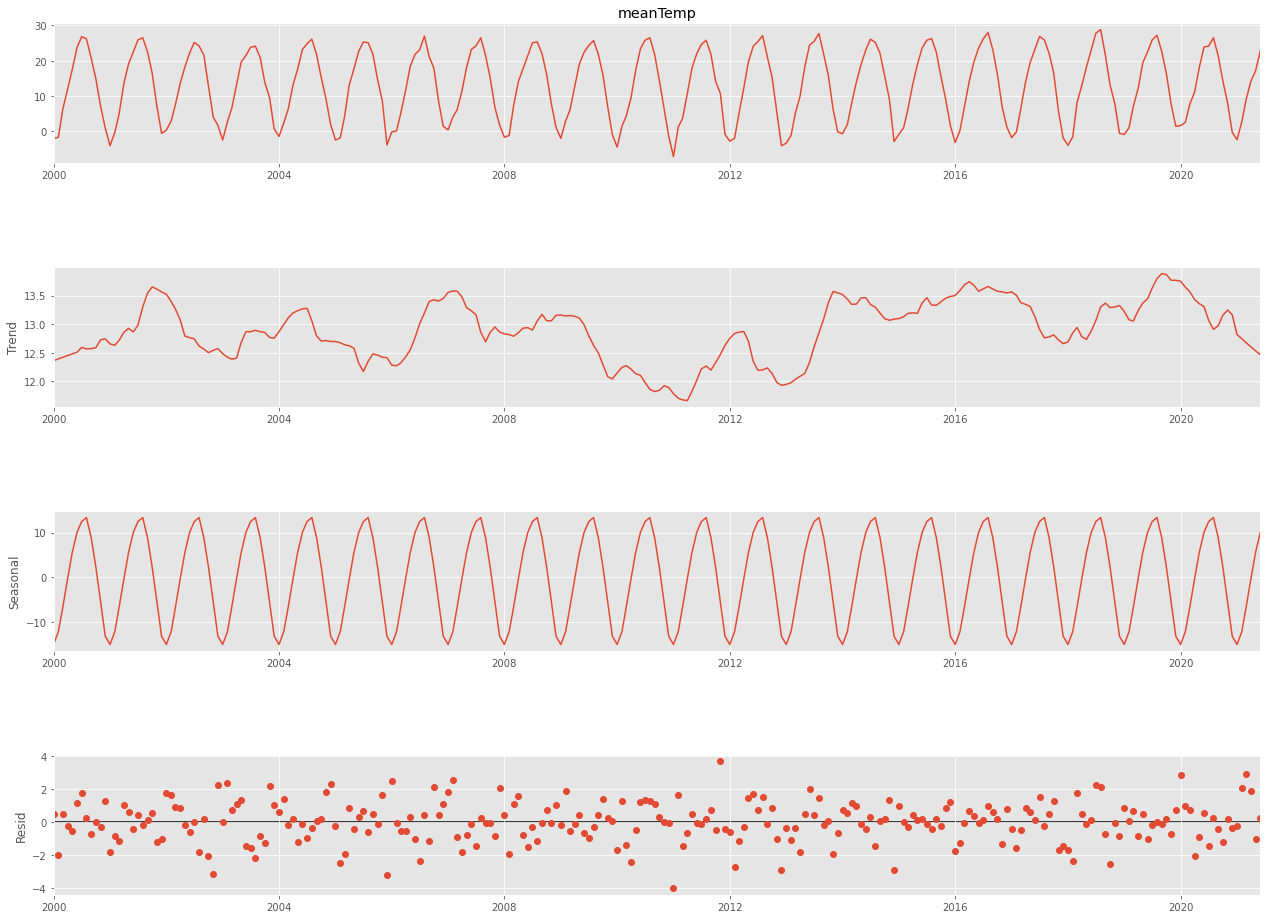

In [95]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts['meanTemp'], model='additive', period=12, extrapolate_trend='freq')

#fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20, 15)
#plt.plot((1,2,3))
#plt.show()

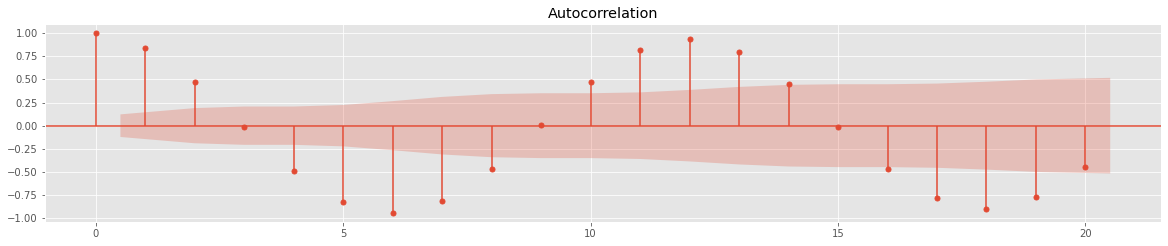

In [96]:
import statsmodels.api as sm
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=20, ax=ax1)
#plt.plot((1,2,3))
#plt.show()

In [97]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # 0.009543 : 정상성 만족
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.609223
p-value: 0.005587
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


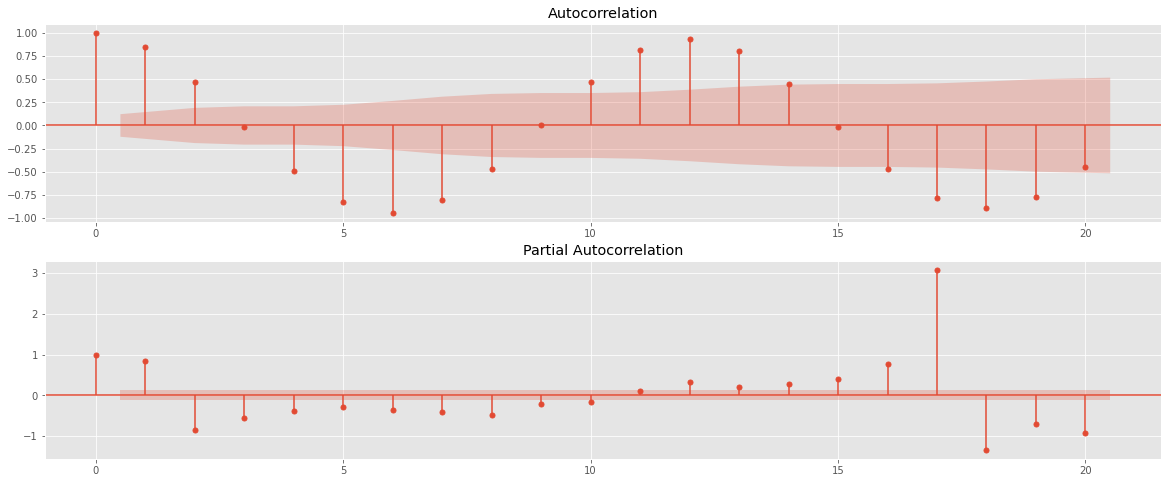

In [98]:
import statsmodels.api as sm

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts[:], lags=20, ax=ax1) # ax2 = fig.add_subplot(212)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts[:], lags=20, ax=ax2) # lags =40
#plt.plot((1,2,3))
#plt.show()

In [100]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime

# 모델 생성 및 학습
model = ARIMA(ts, order=(2,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               meanTemp   No. Observations:                  258
Model:                     ARMA(2, 2)   Log Likelihood                -512.175
Method:                       css-mle   S.D. of innovations              1.717
Date:                Wed, 05 Jan 2022   AIC                           1036.349
Time:                        16:36:58   BIC                           1057.667
Sample:                    01-01-2000   HQIC                          1044.921
                         - 06-01-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.9020      0.102    126.857      0.000      12.703      13.101
ar.L1.meanTemp     1.7321      0.000   7338.195      0.000       1.732       1.733
ar.L2.meanTemp    -1.0000   5.96e-05

In [101]:
start_index = datetime(2018, 1, 1)
end_index = datetime(2021, 6, 1)

forecast = model_fit.predict(start=start_index, end=end_index, typ='levels')

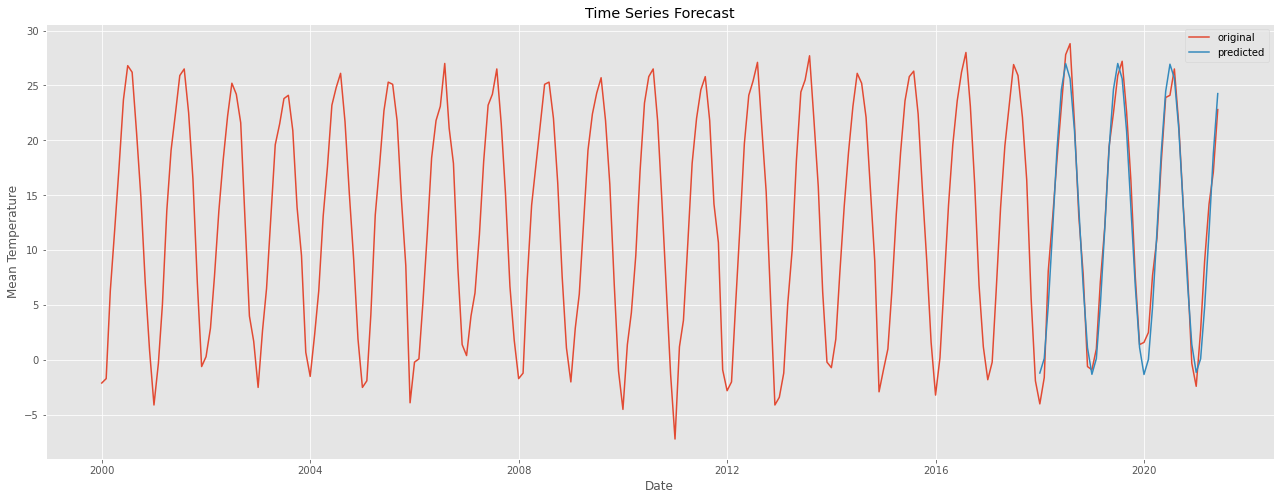

In [104]:
plt.figure(figsize=(22,8))
plt.plot(trainSet.dateTime,trainSet.meanTemp, label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

In [105]:
from sklearn import metrics

def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    corr = round(np.corrcoef(y_true, y_pred)[0,1], 3)
    mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    rmse = round(metrics.mean_absolute_percentage_error(y_true, y_pred), 3)
    df = pd.DataFrame({'R2':r2, 'Corr':corr, 'RMSE':rmse, 'MAPE':mape}, index=[0])
    return df

In [106]:
scoring(np.array(trainSet[trainSet.dateTime >= start_index].meanTemp), np.array(forecast))

,R2,Corr,RMSE,MAPE
0,96.523,0.984,0.468,46.772


In [107]:
forecast_data = model_fit.forecast(steps=12) # steps 값이 향후 예측하고자하는 값.
print(forecast_data)

(array([26.71473115, 25.50293822, 20.91507766, 14.18038702,  7.10327042,
        1.57985038, -0.91004713,  0.30063472,  4.8874755 , 11.62151088,
       18.69851229, 24.22238807]), array([1.71677061, 1.71680801, 1.71686832, 1.71725109, 1.71793324,
       1.71859229, 1.718929  , 1.7189664 , 1.71902657, 1.71940872,
       1.72008991, 1.72074813]), array([[23.34992258, 30.07953972],
       [22.13805635, 28.86782009],
       [17.5500776 , 24.28007773],
       [10.81463672, 17.54613731],
       [ 3.73618313, 10.47035771],
       [-1.7885286 ,  4.94822936],
       [-4.27908607,  2.45899181],
       [-3.06847752,  3.66974695],
       [ 1.51824534,  8.25670565],
       [ 8.25153171, 14.99149005],
       [15.32719801, 22.06982657],
       [20.8497837 , 27.59499244]]))


In [ ]:
pred_y = forecast_data[0].tolist()
test_y = timeSeries_test.MeanTemp.values

In [ ]:
# 마지막 5일의 예측 데이터 최소값
pred_y_lower = []

# 마지막 5일의 예측 데이터 최대값
pred_y_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

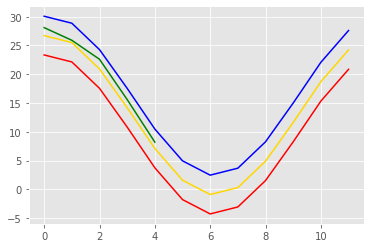

In [ ]:
# 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

In [ ]:
print(ts_test)

            MeanTemp
trainDate           
2021-07-01      28.1
2021-08-01      25.9
2021-09-01      22.6
2021-10-01      15.6
2021-11-01       8.2
